In [46]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("ryanbadai/clothes-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/clothes-dataset


In [47]:
import os

print("Downloaded dataset path:", path)
print("Subfolders:", os.listdir(path))


Downloaded dataset path: /kaggle/input/clothes-dataset
Subfolders: ['Clothes_Dataset']


In [48]:
import os

# ✅ Step 1: Set final dataset path
dataset_root = "/root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset"

# ✅ Step 2: Define top folders and jeans folder
tops_folders = [
    "Kaos",     # T-shirts
    "Polo",     # Polo shirts
    "Kemeja"    # Button-down shirts
]
jeans_folder = os.path.join(dataset_root, "Jeans")


In [49]:
# Install the CLIP model
!pip install transformers

# Load CLIP
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Load CLIP model + processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image embedding
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        return model.get_image_features(**inputs).squeeze().numpy()


In [51]:
def is_top_image(image_path):
    """
    Use CLIP to check if an image looks like a shirt/top.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)

        # Create text embeddings for "a shirt" and "a pair of pants"
        texts = ["a shirt", "a pair of pants"]
        text_inputs = processor(text=texts, return_tensors="pt", padding=True)
        with torch.no_grad():
            text_features = model.get_text_features(**text_inputs)

        # Normalize and calculate similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).squeeze()

        # If it's closer to "a shirt", keep it
        return similarity[0].item() > similarity[1].item()

    except:
        return False  # Skip unreadable images


In [52]:
import numpy as np

top_embeddings = []
top_image_paths = []

for folder in tops_folders:
    folder_path = os.path.join(dataset_root, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # ✅ Use CLIP to check if it's actually a top (shirt)
        if is_top_image(img_path):
            try:
                emb = get_image_embedding(img_path)
                top_embeddings.append(emb)
                top_image_paths.append(img_path)
                print(f"✅ Added top: {img_path}")
            except Exception as e:
                print(f"⚠️ Skipped (error during embedding): {img_path} — {e}")
        else:
            print(f"🧹 Skipped (not a top): {img_path}")



✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/8b89b0a3-2f5c-4dec-ab0d-04604fc9eeeb.jpg
✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/47ca3979-4cf9-4105-abf4-d9ad12fb5fa5.jpg
🧹 Skipped (not a top): /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/8b5fd4f2-bb6a-4155-bed6-0dff7ec7f0c2.jpg
✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/7f82b581-a031-438f-9afc-7a0f111e8ca8.jpg
✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/87f0405b-bdea-4e8a-a0bf-5199dd1a158c.jpg
✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/3c25129a-c68b-4401-b4e4-4b1c089452ac.jpg
✅ Added top: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Kaos/475d03c5-3317-4877-b13d

In [53]:
!pip install faiss-cpu


In [56]:
import faiss
import numpy as np

# Convert list to numpy array
top_embeddings = np.array(top_embeddings)

# Get embedding size (CLIP gives 512-dim vectors)
dimension = top_embeddings.shape[1]

# Create a FAISS index (L2 distance)
index = faiss.IndexFlatL2(dimension)  # L2 = Euclidean distance

# Add all top embeddings
index.add(top_embeddings)

print(f"✅ FAISS index built with {index.ntotal} top items.")

✅ FAISS index built with 1415 top items.


In [61]:
# 1. Choose a jeans image
import random
jeans_images = os.listdir(jeans_folder)
sample_jeans_path = os.path.join(jeans_folder, random.choice(jeans_images))
print("👖 Sample jeans image:", sample_jeans_path)

# 2. Get jeans image embedding
jeans_embedding = get_image_embedding(sample_jeans_path)

import openai

# Set your API key
openai.api_key = ""  # Replace with your OpenAI key

# Optional: describe the jeans based on filename
jeans_desc = os.path.basename(sample_jeans_path).replace("_", " ").replace(".jpg", "")

# Use GPT to generate a styling prompt
gpt_response = openai.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a fashion stylist. Given a jeans description, suggest a top that pairs well in a stylish way."},
        {"role": "user", "content": f"My jeans: {jeans_desc}. What kind of top should I wear with it?"}
    ]
)

# 6. Extract and truncate the prompt for CLIP
prompt = gpt_response.choices[0].message.content
print("🧠 GPT styling prompt:", prompt)

max_tokens = model.config.text_config.max_position_embeddings

# Tokenize with truncation
encoded = processor.tokenizer(
    prompt,
    max_length=max_tokens,
    truncation=True,
    return_tensors="pt"
)

# (Optional) Decode back to readable truncated prompt
prompt = processor.tokenizer.decode(encoded.input_ids[0], skip_special_tokens=True)
print(f"✂️ Properly truncated prompt for CLIP ({len(encoded.input_ids[0])} tokens):", prompt)

# 8. Get CLIP embedding of the prompt
text_inputs = processor(text=[prompt], return_tensors="pt")
with torch.no_grad():
    prompt_embedding = model.get_text_features(**text_inputs).squeeze().numpy()

# 9. Combine jeans image + prompt embeddings
combined_embedding = (jeans_embedding + prompt_embedding) / 2
combined_embedding = combined_embedding.reshape(1, -1)

print("✅ Combined embedding ready for FAISS search.")

👖 Sample jeans image: /root/.cache/kagglehub/datasets/ryanbadai/clothes-dataset/versions/1/Clothes_Dataset/Jeans/b571d681-dbca-42bd-8de4-3f863e8bffe7.jpg
🧠 GPT styling prompt: Sorry, the unique ID you provided doesn't give a clear idea of the color, style, and fit of your jeans, which are important to suggest an appropriate top. Can you please describe your jeans a bit more detailed?
✂️ Properly truncated prompt for CLIP (48 tokens): sorry , the unique id you provided doesn 't give a clear idea of the color , style , and fit of your jeans , which are important to suggest an appropriate top . can you please describe your jeans a bit more detailed ?
✅ Combined embedding ready for FAISS search.


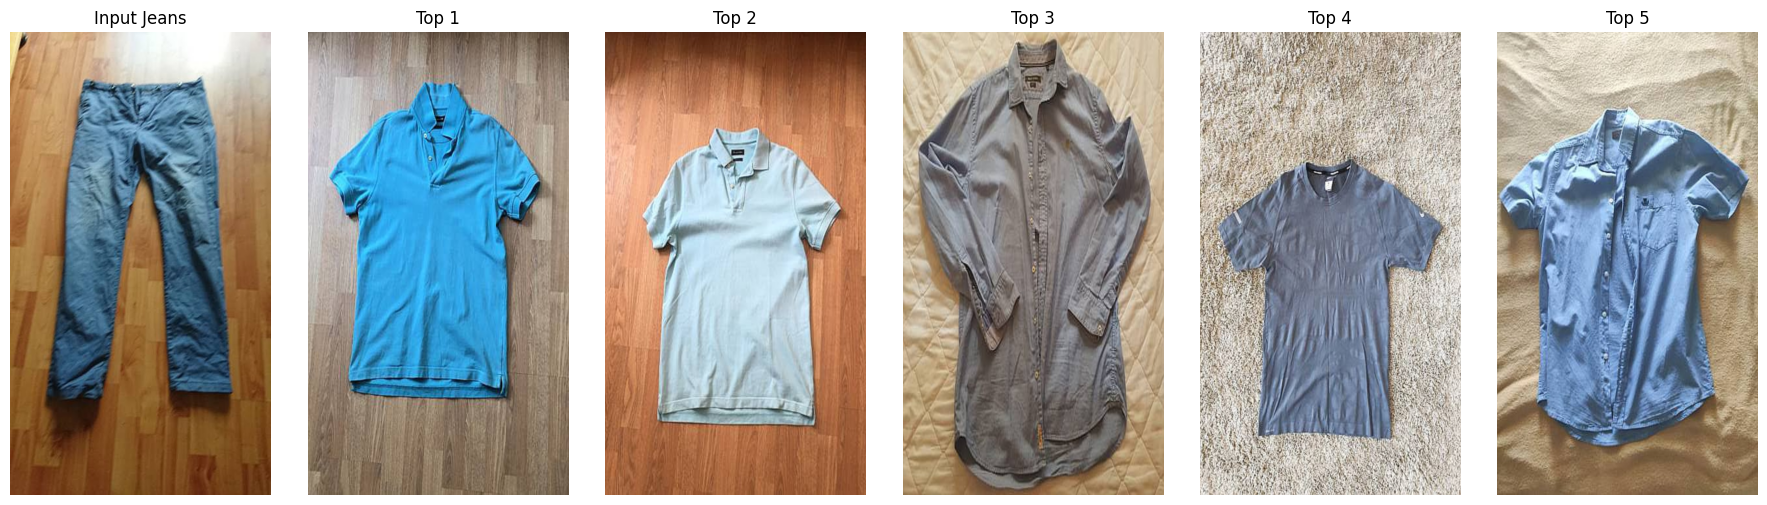

In [62]:
# Query FAISS for top 5 similar tops
k = 5  # Number of recommendations
D, I = index.search(combined_embedding, k)
recommended_paths = [top_image_paths[i] for i in I[0]]

# Display the jeans + recommended tops
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, k + 1, figsize=(18, 5))

# Show input jeans image
axes[0].imshow(Image.open(sample_jeans_path))
axes[0].set_title("Input Jeans")
axes[0].axis("off")

# Show recommended tops
for idx, path in enumerate(recommended_paths):
    axes[idx + 1].imshow(Image.open(path))
    axes[idx + 1].set_title(f"Top {idx + 1}")
    axes[idx + 1].axis("off")

plt.tight_layout()
plt.show()
